#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<font size=3><b>Шаги по выполнению проекта</b></font>

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

## Подготовка

In [1]:
#загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [2]:
#сохраним датасет и установим индекс таблицы равным столбцу datetime
try:
    df_taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

In [3]:
#отсортируем индекс таблицы и ознакомимся с датасетом
df_taxi.sort_index(inplace=True)
df_taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


В датасете всего 2 столбца - с датой и количеством заказов. Проверим типы данных.

In [4]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Типы данных верные: столбец с датой формата `Datetime`, столбец с количеством заказов `num_orders` формата `int64`. В датасете содержатся данные с 00:00 часов 1 марта 2018 г. по 23:50 часов 31 августа 2018 г. Пропусков в датасете нет.

In [5]:
#проверим, упорядочен ли датасет по индексу
print(df_taxi.index.is_monotonic)

True


Датасет упорядочен по индексу, можно приступать к анализу.

## Анализ данных

На данном этапе проведем ресемплирование датасета по 1 часу, а также посмотрим на тренды и сезонность датасета.

In [6]:
#ресемплирование
df_taxi = df_taxi.resample('1H').sum()

Количество строк должно уменьшиться в 6 раз, так как до этого была выгрузка за каждые 10 минут. Проверим.

In [7]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Да, количество строк уменьшилось в 6 раз. Теперь посмотрим на тренды и сезонность.

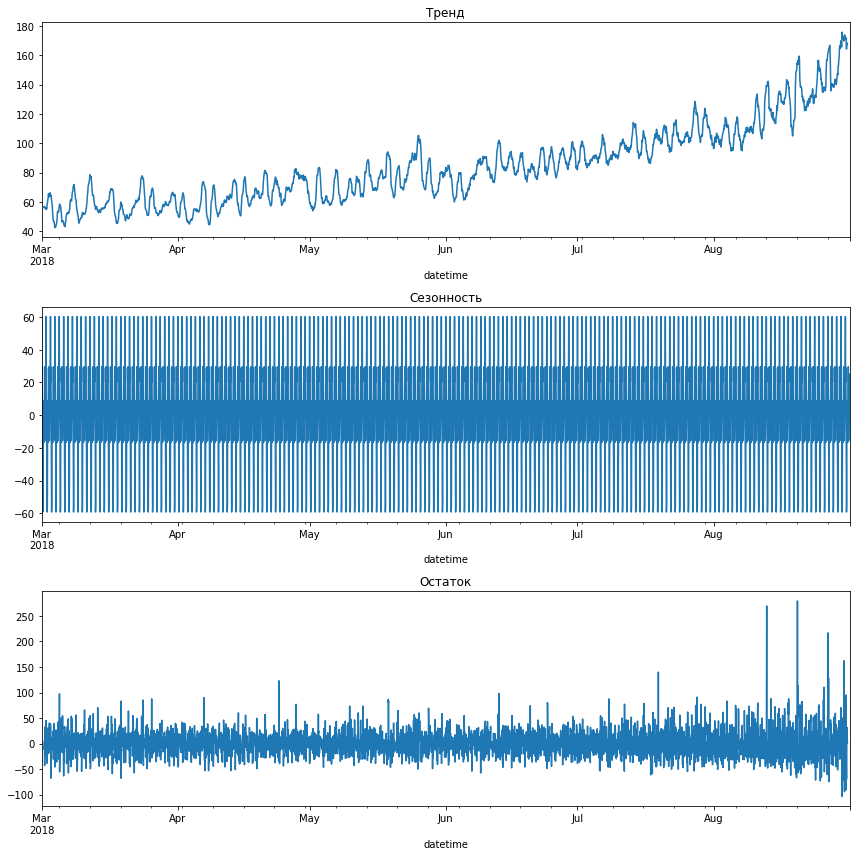

In [8]:
decomposed = seasonal_decompose(df_taxi)

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток')
plt.tight_layout()

По тренду видим, что количество заказов такси стало непрерывно увеличиваться с июня. По сезонности ничего не понятно, возьмем отрезок времени за последний месяц выборки - август.

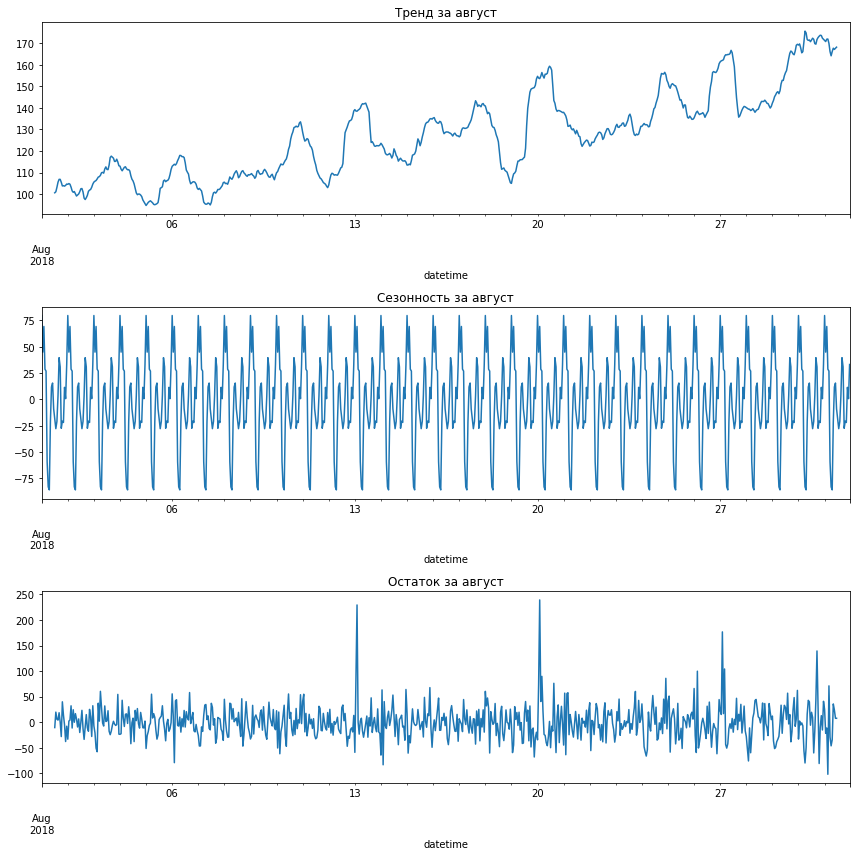

In [9]:
decomposed_aug = seasonal_decompose(df_taxi['2018-08-01':'2018-08-31'])

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_aug.trend.plot(ax=plt.gca())
plt.title('Тренд за август')

plt.subplot(312)
decomposed_aug.seasonal.plot(ax=plt.gca())
plt.title('Сезонность за август')

plt.subplot(313)
decomposed_aug.resid.plot(ax=plt.gca())
plt.title('Остаток за август')
plt.tight_layout()

Также видим рост тренда в течение всего августа, а сезонность снова показывает полную стабильность, как кардиограмма космонавта. Рассмотрим сезонность в разрезе одного дня, чтобы можно было сделать какие-то выводы.

Text(0.5, 1.0, 'Сезонность за день')

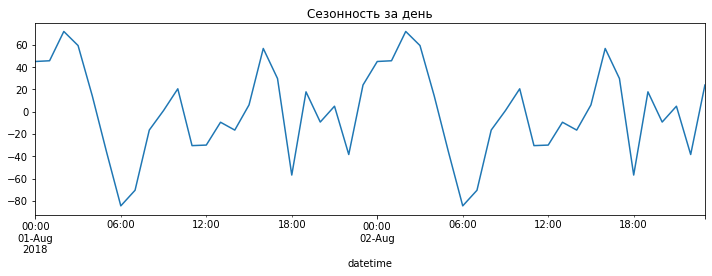

In [10]:
decomposed_day = seasonal_decompose(df_taxi)['2018-08-01':'2018-08-02']
plt.figure(figsize=(12, 12))
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Сезонность за день')

Теперь лучше видно, что в 6 утра начинается рост количества заказов, затем резкое падение количества заказов с 11 до 12 часов дня, затем снова рост количества заказов до 16 часов дня, затем снова падение, и потом рост количества заказов с 18 часов и до 2 часов ночи, после чего идет резкое снижение заказов и в 6 утра начинается новый цикл. Пик заказов приходится на временной отрезок с 0 до 2 часов ночи.

## Обучение

### Подготовка признаков

Подготовим наш датасет к работе с моделями. Для этого мы:
1. Создадим дополнительные признаки для датасета.
2. Создадим константную модель для проверки наших моделей на адекватность.
3. Подготовим обучающую и тестовую выборки в соотношении 9:1.

Создадим новые признаки для датасета:
1. Календарные признаки (месяц, день, день недели).
2. Отстающие значения.
3. Скользящее среднее.

In [11]:
#создадим функцию расчета RMSE
def rmse(target, prediction):
    return mean_squared_error(target, prediction)**0.5

In [12]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy(deep=True)
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

#возьмем произвольные значения
df = make_features(df_taxi, 30, 40)

In [13]:
#проверим новый датасет
df.sample(10)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-05-23 19:00:00,81,5,23,2,46.0,55.0,121.0,116.0,111.0,44.0,...,77.0,77.0,76.0,44.0,64.0,124.0,60.0,62.0,66.0,71.750
2018-08-15 12:00:00,90,8,15,2,120.0,166.0,131.0,92.0,28.0,36.0,...,112.0,64.0,114.0,162.0,155.0,135.0,91.0,54.0,45.0,117.775
2018-08-08 06:00:00,60,8,8,2,86.0,104.0,104.0,157.0,154.0,230.0,...,79.0,44.0,46.0,50.0,108.0,121.0,125.0,101.0,156.0,105.775
2018-06-09 15:00:00,97,6,9,5,90.0,86.0,91.0,74.0,65.0,89.0,...,82.0,121.0,80.0,85.0,78.0,72.0,117.0,124.0,116.0,86.700
2018-04-06 20:00:00,105,4,6,4,63.0,49.0,79.0,98.0,86.0,59.0,...,89.0,63.0,61.0,35.0,45.0,38.0,98.0,66.0,34.0,54.875
2018-05-17 02:00:00,139,5,17,3,80.0,156.0,119.0,89.0,64.0,63.0,...,88.0,92.0,104.0,57.0,91.0,123.0,67.0,71.0,65.0,72.400
2018-03-14 17:00:00,57,3,14,2,59.0,51.0,72.0,67.0,41.0,58.0,...,40.0,109.0,35.0,64.0,69.0,50.0,40.0,34.0,75.0,52.050
2018-08-31 15:00:00,116,8,31,4,133.0,166.0,136.0,167.0,191.0,203.0,...,342.0,254.0,156.0,91.0,154.0,173.0,156.0,227.0,226.0,168.975
2018-03-20 16:00:00,75,3,20,1,74.0,29.0,44.0,30.0,43.0,58.0,...,57.0,65.0,44.0,48.0,50.0,45.0,39.0,83.0,69.0,50.400


Проверим RMSE на двух константных моделях: прогноз медианы и прогноз предыдущего значения ряда.

In [14]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

#константная модель, прогнозирующая медиану
pred_median = np.ones(test.shape) * train['num_orders'].median()
rmse_median = mean_squared_error(test, pred_median)**0.5
print("RMSE константной модели, прогнозирующей медиану:", rmse_median)

#константная модель, прогнозирующая предыдущее значение ряда
pred_previous = pd.Series(train['num_orders'].iloc[-len(test):])
print("RMSE константной модели, прогнозирующей предыдущее значение ряда:",
      rmse(test['num_orders'], pred_previous))

RMSE константной модели, прогнозирующей медиану: 84.54772153207533
RMSE константной модели, прогнозирующей предыдущее значение ряда: 81.82849573915023


In [15]:
#подготовим обучающую и тестовую выборки
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print('Размер обучающей выборки:', features_train.shape)
print('Размер тестовой выборки:', features_test.shape)

Размер обучающей выборки: (3934, 34)
Размер тестовой выборки: (442, 34)


Можно приступать к обучению моделей.

### Линейная регрессия

In [16]:
#здесь используем стандартные параметры

linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
 
linear_prediction = linear_model.predict(features_train)
print('RMSE линейной регрессии составляет:', rmse(target_train, linear_prediction))

RMSE линейной регрессии составляет: 25.162063268252812


Линейная регрессия продемонстрировала очень хороший результат RMSE - 25.16. Посмотрим, что покажут более сложные модели.

### Случайный лес

In [17]:
tss = TimeSeriesSplit(n_splits = 5)

forest_model = RandomForestRegressor(random_state=12345)
forest_params = {'n_estimators':range(10, 50, 10), 'max_depth':range(10, 20)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=tss, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
forest_grid.fit(features_train, target_train)
forest_prediction = forest_grid.predict(features_train)

print('Лучшие параметры случайного леса:', forest_grid.best_params_)
print('RMSE случайного леса составляет:', rmse(target_train, forest_prediction))

Лучшие параметры случайного леса: {'max_depth': 17, 'n_estimators': 40}
RMSE случайного леса составляет: 9.437120311120644


RMSE случайного леса на обучающей выборке составил 9,43. 

### Catboost

In [18]:
cat_model = CatBoostRegressor(iterations=100, verbose=False, random_state=12345)
cat_params = {'learning_rate':[0.1, 0.2], #скорость обучения
              'depth':[10, 15, 20]} #depth - глубина дерева
cat_grid = GridSearchCV(cat_model, cat_params, cv=tss, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
cat_grid.fit(features_train, target_train)
cat_prediction = cat_grid.predict(features_train)

print('Лучшие параметры Catboost:', cat_grid.best_params_)
print('RMSE Catboost составляет:', rmse(target_train, cat_prediction))

Лучшие параметры Catboost: {'depth': 10, 'learning_rate': 0.1}
RMSE Catboost составляет: 14.407305245937813


Catboost показал результат RMSE хуже, чем лес: 14.40.

### LightGBM

In [19]:
gbm_model = LGBMRegressor(random_state=12345)
gbm_params = {'n_estimators':[100, 150], #количество деревьев решений
              'num_leaves':[10, 15, 20]} #количество терминальных узлов (листьев) дерева
gbm_grid = GridSearchCV(gbm_model, gbm_params, cv=tss, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
gbm_grid.fit(features_train, target_train)
gbm_prediction = gbm_grid.predict(features_train)

print('Лучшие параметры LightGBM OE:', gbm_grid.best_params_)
print('RMSE LightGBM составляет:', rmse(target_train, gbm_prediction))

Лучшие параметры LightGBM OE: {'n_estimators': 150, 'num_leaves': 10}
RMSE LightGBM составляет: 16.947848800689265


LightGBM продемонстрировал результат еще хуже, чем случайный лес и Catboost и его RMSE составил 16.94.

### Вывод по моделям

1. Все 4 модели продемонстрировали результат RMSE ниже 48.
2. Самый лучший результат продемонстрировали случайный лес и Catboost, именно их и проверим на тестовой выборке.

## Тестирование

Создадим сравнительную таблицу с результатами RMSE.

In [20]:
data={'Модель': ['Linear Regression', 'RandomForest', 'CatBoost', 'LightGBM', 'Constant Median', 'Constant Previous'],
      'RMSE': [25.16, 9.43, 14.40, 16.94, 84.54, 81.82]}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Модель,RMSE
0,Linear Regression,25.16
1,RandomForest,9.43
2,CatBoost,14.40
3,LightGBM,16.94
4,Constant Median,84.54
5,Constant Previous,81.82


Проверим RMSE случайного леса и Catboost на тестовой выборке.

In [21]:
forest = RandomForestRegressor(random_state=12345, max_depth=17, n_estimators=40)
forest.fit(features_train, target_train)
forest_pred = forest.predict(features_test)
print('RMSE случайного леса на тестовой выборке составляет:', rmse(target_test, forest_pred))

RMSE случайного леса на тестовой выборке составляет: 43.78905280006859


In [22]:
catboost = CatBoostRegressor(iterations=100, verbose=False, random_state=12345,
                            learning_rate=0.1, depth=10)
catboost.fit(features_train, target_train)
catboost_pred = catboost.predict(features_test)
print('RMSE Catboost на тестовой выборке составляет:', rmse(target_test, catboost_pred))

RMSE Catboost на тестовой выборке составляет: 46.54525607876236


На тестовой выборке RMSE оказался в разы хуже, чем на обучающей выборке, но все-равно в порог RMSE до 48 модели уложились. Лучший результат показал случайный лес с результатов 43.78.

Посмотрим на график важности факторов.

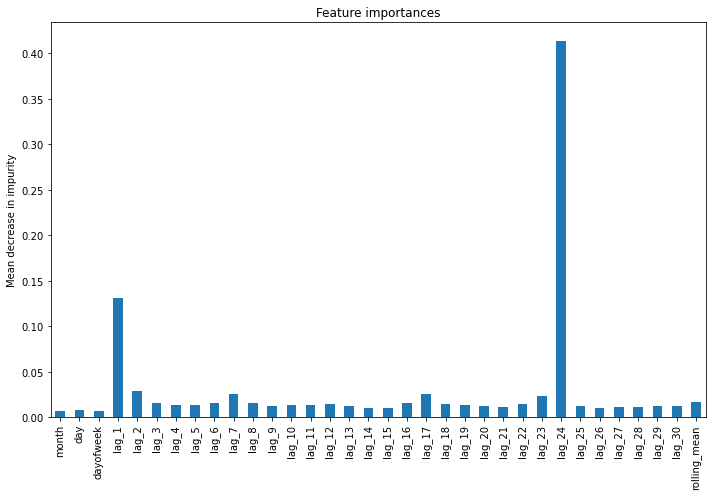

In [23]:
feature_names = features_train.columns 
model = RandomForestRegressor(n_estimators=40, max_depth=18, random_state=12345)
model.fit(features_train, target_train)
pred = model.predict(features_test)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

И посмотрим на графике, как соотносятся предсказания модели с актуальными данными из выгрузки по заказам.

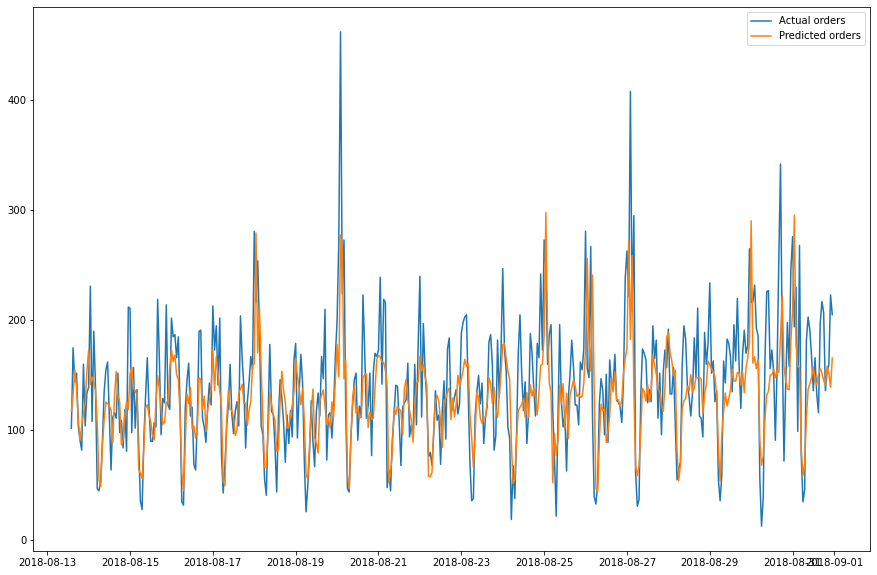

In [24]:
plt.figure(figsize=(15, 10))
plt.plot(features_test.index, target_test, label='Actual orders')
plt.plot(features_test.index, forest_pred, label='Predicted orders')
plt.legend()
plt.show()

На графике видно, что модель в целом с предсказаниями справляется неплохо, за исключением редких больших пиковых значений.

## Выводы

1. В датасете всего 2 столбца - с датой и количеством заказов. Типы данных верные: столбец с датой формата Datetime, столбец с количеством заказов num_orders формата int64. В датасете содержатся данные с 00:00 часов 1 марта 2018 г. по 23:50 часов 31 августа 2018 г. Пропусков в датасете нет. Датасет упорядочен по индексу, можно приступать к анализу.
2. Было проведено ресемплирование датасета по 1 часу. По тренду видно, что количество заказов такси стало непрерывно увеличиваться с июня. По сезонности видно, что пик заказов приходится на временной отрезок с 0 до 2 часов ночи.
3. При подготовке датасета к работе с моделями:
    1. Были создаеы дополнительные признаки для датасета: месяц, день, день недели, отстающие значения, скользящее среднее.
    2. Создана константная модель для проверки наших моделей на адекватность.
    3. Подготовлена обучающая и тестовая выборки в соотношении 9:1.
4. RMSE константной модели, прогнозирующей медиану составил 84.54772153207533. RMSE константной модели, прогнозирующей предыдущее значение ряда составил 81.82849573915023.
5. Были обучены 4 модели, которые показали следующие результаты на обучающей выборке.
    1. RMSE линейной регрессии составляет 25.16.
    2. RMSE случайного леса на обучающей выборке составил 9,43.
    3. RMSE Catboost составил 14.40.
    4. LightGBM продемонстрировал результат хуже, чем случайный лес и Catboost и его RMSE составил 16.94.
6. Для проверки RMSE на тестовой выборке были выбраны 2 модели:
    1. RMSE случайного леса на тестовой выборке составил 43.78.
    2. RMSE Catboost на тестовой выборке составил 46.54.
7. В качестве основной модели для продакшна был выбран случайный лес.
8. Обе проверенные модели на тестовой выборке не превысили порог RMSE, равный 48.